In [53]:
import cv2
import numpy as np
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import sklearn
from tqdm import tqdm

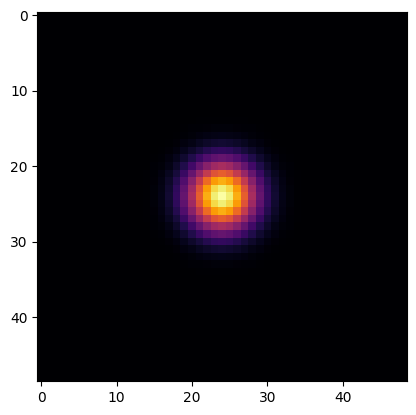

In [54]:
def GaussFilter(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    g = (1/(2*np.pi * sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    #normalisng it - sometimes the sum is not perfectly 1...
    g /= np.sum(g)
    # print(np.sum(g))
    return g

test_gauss = GaussFilter(49, 10**0.5)
plt.imshow(test_gauss, cmap="inferno")

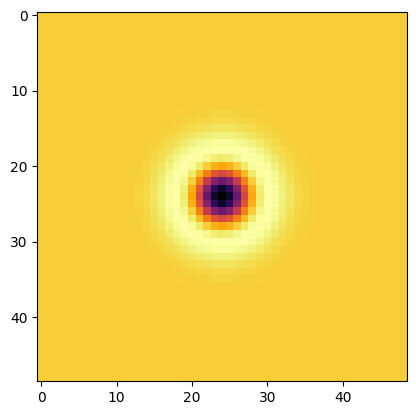

In [55]:
def LoG(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = -((1)/(np.pi * sigma ** 4 )) * \
        (1- (x**2 + y**2)/(2* sigma **2)) * \
        np.exp(-(x**2 + y**2)/(2*sigma**2))
    

    return g
test_log = LoG(49, 10**0.5)
plt.imshow(test_log,cmap="inferno")

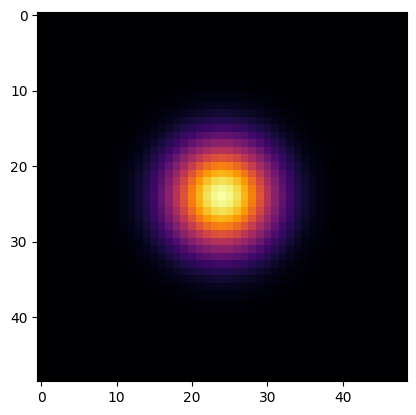

In [56]:
def DoG(size, sigma, K):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = (1/(2 * np.pi * sigma **2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * sigma **2)) - \
        (1/ (2 * np.pi * K**2 *sigma**2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * K**2 * sigma **2))

    return g 
    
test_dog = DoG(49, 5, 10)
plt.imshow(test_dog,cmap="inferno")

In [57]:
def getLBPs(img,show_plot=False):
    lbps = []
    radii = [4, 8, 16, 24, 32]
    for radius in radii:
        lbp = skimage.feature.local_binary_pattern(img,12,radius,'uniform')
        lbps.append(lbp)

    if show_plot:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i, (img, label) in enumerate(zip(lbps, radii)):
            axes[i].imshow(img, cmap="gray")
            axes[i].axis('off')
            axes[i].set_title(label)  

        plt.tight_layout()
        plt.show()

    return np.array(lbps)

In [58]:
def apply_haar_filter(integral_images, filter_size,show_plot=False):
    h, w = integral_images[0].shape
    # integral images have a buffer at the end of each axis
    h= h-1
    w= w-1
    response = np.zeros((len(integral_images),h,w))
    
    for i in range(len(integral_images)):  # For each channel (R, G, B)
        integral_image = integral_images[i]
        
        for y in range(h):
            for x in range(w):
                A = integral_image[max(0,y - filter_size//2),max(0,x - filter_size//2)]
                B = integral_image[max(0,y - filter_size//2),min(w,x + filter_size//2)]
                C = integral_image[min(h,y + filter_size//2),max(0,x - filter_size//2)]
                D = integral_image[min(h,y + filter_size//2), min(w,x + filter_size//2)]
                
                pos_sum = A + D
                
                neg_sum = B + C
                
                response[i,y,x] = pos_sum - neg_sum

    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i  in range(response.shape[0]):
            axes[i].imshow(response[i].astype(np.uint8), )
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
                
    return response

In [59]:
def getFeatures(training_img, mask, show_plot=False,MR8:bool = False, texton:bool = False):
        """
        Parameters:
            training_img (2d array): training image.
            mask (type): binarized image.

        Returns:
            type: Flattened features.
        """
        #if(type(mask[0][0]) != np.bool_):
        #    binary_mask = mask >128

        vertical_prewitt = np.array([
            [1,1,1],
            [0,0,0],
            [-1,-1,-1]
        ])
        horizontal_prewitt = np.array([
            [1,0,-1],
            [1,0,-1],
            [1,0,-1]
        ])

        laplacian = np.array([
            [0,-1,0],
            [-1,4,-1],
            [0,-1,0]
        ])

        gauss = GaussFilter(49, 10**0.5)
        lgauss =  LoG(49, 10**0.5)
        dgauss = DoG(49,5,10)

        binary_mask = mask>128
        #plt.imshow(binary_mask)
        
        #add dimensions
        # print(binary_mask.shape)
        hsv_training_img = cv2.cvtColor(training_img, cv2.COLOR_BGR2RGB)
        v,s,h = cv2.split(hsv_training_img)
        h, s,v = h*binary_mask, s*binary_mask, v*binary_mask
        # print(h.shape)
        b,g,r = cv2.split(training_img)
        r,g,b = r*binary_mask, g*binary_mask, b*binary_mask


        # get vertical prewitt for separated channels

        vert_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=vertical_prewitt)
        # get horizontal prewitt for separated channels

        hori_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=horizontal_prewitt)
        # get Laplacian for separated channels

        laplace_r = cv2.filter2D(src=r, ddepth=-1, kernel=laplacian)
        laplace_g = cv2.filter2D(src=g, ddepth=-1, kernel=laplacian)
        laplace_b = cv2.filter2D(src=b, ddepth=-1, kernel=laplacian)

        # get gaussian for seperate channels
        gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = gauss)
        gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = gauss)
        gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = gauss)

        # get log of gaussian for seperate channels
        l_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = lgauss)
        l_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = lgauss)
        l_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = lgauss)

        # get log of gaussian for seperate channels
        d_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = dgauss)
        d_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = dgauss)
        d_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = dgauss)

        # get LBPs for seperate channels
        lbp_r = getLBPs(r)
        lbp_g = getLBPs(g)
        lbp_b = getLBPs(b)

        # get Harr for seperate channels and sizes
        integral_images = [cv2.integral(training_img[:,:,i]) for i in range(3)]
        haar4 = apply_haar_filter(integral_images,4)
        haar8 = apply_haar_filter(integral_images,8)
        haar16 = apply_haar_filter(integral_images,16)

        if show_plot:
            # vertical prewitt plot 
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( vert_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( vert_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( vert_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Vertical Prewitt of RGB image")
            plt.show()

            # horizontal prewitt plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( hori_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( hori_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( hori_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Horizontal Prewitt of RGB image")
            plt.show()

            # laplace plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( laplace_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( laplace_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( laplace_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Laplacian of RGB image")
            plt.show()

            # gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Gaussian of RGB image")
            plt.show()


            # log of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( l_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( l_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( l_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Log of Gaussian of RGB image")
            plt.show()

            # difference of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( d_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( d_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( d_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Difference of Gaussian of RGB image")
            plt.show()

            # LBP Red plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_r, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Red image")
            plt.show()

            # LBP Green plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_g, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Green image")
            plt.show()

            # LBP Blue plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_b, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Blue image")
            plt.show()

            # Haar4 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar4.shape[0]):
                axes[i].imshow(haar4[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 4 of RGB image")
            plt.show()

            # Haar8 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar8.shape[0]):
                axes[i].imshow(haar8[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 8 of RGB image")
            plt.show()

            # Haar16 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar16.shape[0]):
                axes[i].imshow(haar16[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 16 of RGB image")
            plt.show()


        features = [
            vert_prewitt_r, hori_prewitt_r, 
            vert_prewitt_g, hori_prewitt_g, 
            vert_prewitt_b, hori_prewitt_b, 
            laplace_r, laplace_g, laplace_b,
            gauss_r, l_gauss_r, d_gauss_r,
            gauss_g, l_gauss_g, d_gauss_g,
            gauss_b, l_gauss_b, d_gauss_b,
            lbp_r[0],lbp_r[1],lbp_r[2],lbp_r[3],lbp_r[4],
            lbp_g[0],lbp_g[1],lbp_g[2],lbp_g[3],lbp_g[4],
            lbp_b[0],lbp_b[1],lbp_b[2],lbp_b[3],lbp_b[4],
            haar4[0],haar4[1],haar4[1],
            haar8[0],haar8[1],haar8[1],
            haar16[0],haar16[1],haar16[1],
            r, g, b,
            h, s, v,
        ]

            
        flattened_features = np.array([f[binary_mask].flatten() for f in features])
        # print(flattened_features[0].shape)

        return np.array(flattened_features)

c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(270000,)


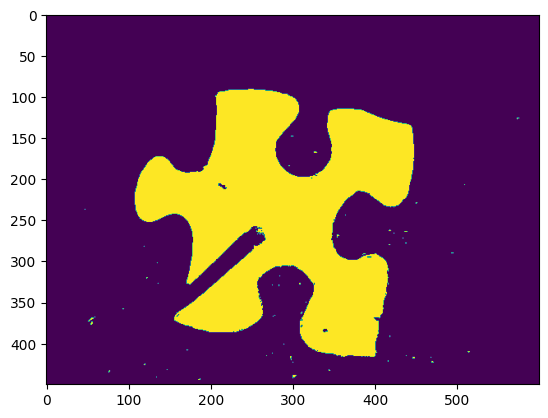

In [60]:
import sklearn.linear_model


image = cv2.imread("Images/image-35.jpg")
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
mask = mask>=127.5
null = np.ones_like(mask)*255
original_features = getFeatures(image,null,False)

perpixel_features = np.swapaxes(original_features,0,1)

log_reg = sklearn.linear_model.LogisticRegression().fit(perpixel_features,mask.flatten())

ver = cv2.imread("Images/image-110.jpg")
mask = cv2.imread("Images/mask-83.png", cv2.IMREAD_GRAYSCALE)
mask = mask>=127.5
ver_features = getFeatures(ver,null,False)
ver_perpixel_features = np.swapaxes(ver_features,0,1)

predictions = log_reg.predict(ver_perpixel_features)
print(predictions.shape)

plt.imshow(predictions.reshape(450,600))

